In [ ]:
!pip install jiwer -q
import os
import json
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import math
import random
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from jiwer import cer, wer

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import zipfile

# Thiết lập device - Mặc định là GPU
device = torch.device('cuda')


# Thiết lập seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Vintextnew.zip"
extract_path = "/content/VintextDataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Đã giải nén.")

Mounted at /content/drive
Đã giải nén.


In [ ]:
ROOT_DATA_DIR = '/content/VintextDataset/Vintextnew'
TRAIN_IMG_ROOT_DIR = os.path.join(ROOT_DATA_DIR, 'train_images')
VAL_IMG_ROOT_DIR = os.path.join(ROOT_DATA_DIR, 'val_image')
TEST_IMG_ROOT_DIR = os.path.join(ROOT_DATA_DIR, 'test_images')

TRAIN_LABEL_FILE = os.path.join(ROOT_DATA_DIR, 'train_vintext_label.txt')
VAL_LABEL_FILE = os.path.join(ROOT_DATA_DIR, 'val_vintext_label.txt')
TEST_LABEL_FILE = os.path.join(ROOT_DATA_DIR, 'test_vintext_label.txt')

OUTPUT_DIR = '/content/vintext_output/'
PROCESSED_TRAIN_WORDS_DIR = os.path.join(OUTPUT_DIR, 'processed_words/train')
PROCESSED_VAL_WORDS_DIR = os.path.join(OUTPUT_DIR, 'processed_words/val')
PROCESSED_TEST_WORDS_DIR = os.path.join(OUTPUT_DIR, 'processed_words/test')

PROCESSED_TRAIN_CSV = os.path.join(OUTPUT_DIR, 'train_processed_vintext.csv')
PROCESSED_VAL_CSV = os.path.join(OUTPUT_DIR, 'val_processed_vintext.csv')
PROCESSED_TEST_CSV = os.path.join(OUTPUT_DIR, 'test_processed_vintext.csv')

VOCAB_PATH = os.path.join(OUTPUT_DIR, 'vintext_vocab.json')
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'vintext_ocr_model_best.pth')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PROCESSED_TRAIN_WORDS_DIR, exist_ok=True)
os.makedirs(PROCESSED_VAL_WORDS_DIR, exist_ok=True)
os.makedirs(PROCESSED_TEST_WORDS_DIR, exist_ok=True)


RECTIFIED_IMG_TARGET_HEIGHT = 32
RECTIFIED_IMG_TARGET_WIDTH = 128

INITIAL_MAX_TEXT_LEN = 35
VOCAB_SIZE = 0

EMBED_DIM = 256
CNN_BACKBONE_OUTPUT_CHANNELS = 512
NHEAD = 4
NUM_DECODER_LAYERS = 4
DIM_FEEDFORWARD_DECODER = EMBED_DIM * 4
DROPOUT = 0.2

BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
CLIP_VALUE = 1.0

print(f"ROOT_DATA_DIR: {ROOT_DATA_DIR}")
print(f"TRAIN_LABEL_FILE: {TRAIN_LABEL_FILE}")
print(f"VAL_LABEL_FILE: {VAL_LABEL_FILE}")
print(f"TEST_LABEL_FILE: {TEST_LABEL_FILE}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"VOCAB_PATH: {VOCAB_PATH}")
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")


PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0,0,0,0
MAX_TEXT_LEN = INITIAL_MAX_TEXT_LEN

ROOT_DATA_DIR: /content/VintextDataset/Vintextnew
TRAIN_LABEL_FILE: /content/VintextDataset/Vintextnew/train_vintext_label.txt
VAL_LABEL_FILE: /content/VintextDataset/Vintextnew/val_vintext_label.txt
TEST_LABEL_FILE: /content/VintextDataset/Vintextnew/test_vintext_label.txt
OUTPUT_DIR: /content/vintext_output/
VOCAB_PATH: /content/vintext_output/vintext_vocab.json
MODEL_SAVE_PATH: /content/vintext_output/vintext_ocr_model_best.pth


In [ ]:
# Cell 3: Hàm Đọc và Phân tích Chú thích VinText từ file .txt


def parse_vintext_label_file(label_file_path, image_root_dir=""):
    """
    Đọc và phân tích file label .txt của VinText.

    Args:
        label_file_path (str): Đường dẫn đến file .txt chứa chú thích.
        image_root_dir (str): Đường dẫn gốc đến thư mục chứa các thư mục con của ảnh
                              (ví dụ: 'train_images/', 'test_images/').
                              Dùng để ghép với đường dẫn tương đối trong file label.
                              Nếu đường dẫn trong file label đã là tuyệt đối hoặc
                              tương đối từ một gốc khác mà bạn xử lý riêng, có thể để trống.

    Returns:
        list: Danh sách các dictionary, mỗi dictionary chứa 'image_path',
              'polygon_points', và 'text' cho một từ/cụm từ.
              Trả về list rỗng nếu file không tồn tại hoặc có lỗi.
    """
    all_word_annotations = []

    if not os.path.exists(label_file_path):
        print(f"Lỗi: Không tìm thấy file label: {label_file_path}")
        return all_word_annotations

    try:
        with open(label_file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        print(f"Đọc {len(lines)} dòng từ file: {label_file_path}")

        for line in tqdm(lines, desc=f"Processing lines in {os.path.basename(label_file_path)}"):
            line = line.strip()
            if not line:
                continue

            parts = line.split('\t', 1) # Tách tối đa 1 lần tại ký tự tab
            if len(parts) != 2:
                # print(f"Cảnh báo: Dòng không đúng định dạng (thiếu tab phân tách): {line[:100]}...")
                continue

            relative_image_path, json_annotations_str = parts

            # Xây dựng đường dẫn tuyệt đối đến ảnh
            # Giả định image_root_dir là thư mục cha chứa các thư mục con như 'train_images', 'val_images'
            # và relative_image_path có dạng 'train_images/imXXXX.jpg'
            # Nếu image_root_dir là ROOT_DATA_DIR, thì sẽ là ROOT_DATA_DIR/train_images/imXXXX.jpg
            # Hoặc nếu relative_image_path đã là đường dẫn đầy đủ từ một gốc nào đó thì image_root_dir có thể là ''
            if image_root_dir: # Nếu image_root_dir được cung cấp và không rỗng
                full_image_path = os.path.join(image_root_dir, relative_image_path)
            else: # Nếu không, giả sử relative_image_path đã là đường dẫn có thể dùng được
                full_image_path = relative_image_path

            # Kiểm tra xem file ảnh có thực sự tồn tại không (tùy chọn, có thể làm chậm quá trình)
            # if not os.path.exists(full_image_path):
            #     print(f"Cảnh báo: File ảnh không tồn tại: {full_image_path} cho dòng: {line[:50]}")
            #     continue

            try:
                word_list_json = json.loads(json_annotations_str) # Parse chuỗi JSON thành list các dict

                for word_info in word_list_json:
                    transcription = word_info.get('transcription', '').strip()
                    points_list = word_info.get('points', [])

                    if transcription and points_list and isinstance(points_list, list) and len(points_list) >= 3:
                        # Kiểm tra mỗi điểm là list 2 phần tử
                        if all(isinstance(pt, list) and len(pt) == 2 for pt in points_list):
                            try:
                                polygon_points_np = np.array(points_list, dtype=np.int32)
                                all_word_annotations.append({
                                    'image_path': full_image_path,
                                    'polygon_points': polygon_points_np,
                                    'text': transcription
                                })
                            except Exception as e_np:
                                print(f"Lỗi khi chuyển đổi sang np.array cho từ '{transcription}' trong ảnh {relative_image_path}: {e_np}")
                        # else:
                            # print(f"Cảnh báo: Cấu trúc điểm không hợp lệ cho từ '{transcription}' trong ảnh {relative_image_path}")
                    # else:
                        # if not transcription:
                        #     print(f"Cảnh báo: Thiếu transcription cho một từ trong ảnh {relative_image_path}")
                        # if not (points_list and isinstance(points_list, list) and len(points_list) >= 3):
                        #     print(f"Cảnh báo: Thiếu hoặc không đủ điểm đa giác cho từ '{transcription}' trong ảnh {relative_image_path}")

            except json.JSONDecodeError:
                print(f"Lỗi: Chuỗi JSON không hợp lệ cho ảnh {relative_image_path}: {json_annotations_str[:100]}...")
            except Exception as e_parse_word:
                print(f"Lỗi khi xử lý một từ trong ảnh {relative_image_path}: {e_parse_word}")

    except Exception as e_read_file:
        print(f"Lỗi không xác định khi đọc file {label_file_path}: {e_read_file}")

    return all_word_annotations

print("Đã định nghĩa hàm parse_vintext_label_file.")

# --- Thử nghiệm hàm với file train_vintext_label.txt ---
# Đảm bảo TRAIN_LABEL_FILE và ROOT_DATA_DIR (hoặc một image_root_dir phù hợp) đã được định nghĩa ở Cell 2
if 'TRAIN_LABEL_FILE' in globals() and os.path.exists(TRAIN_LABEL_FILE) and 'ROOT_DATA_DIR' in globals():
    print(f"\n--- Thử nghiệm đọc file: {TRAIN_LABEL_FILE} ---")
    # Sử dụng ROOT_DATA_DIR làm image_root_dir nếu đường dẫn ảnh trong file label là tương đối với nó
    # ví dụ: train_images/imgXXX.jpg
    train_annotations_vintext = parse_vintext_label_file(TRAIN_LABEL_FILE, ROOT_DATA_DIR)

    if train_annotations_vintext:
        print(f"Tìm thấy {len(train_annotations_vintext)} từ được chú thích trong file train.")
        print("Ví dụ 5 từ đầu tiên:")
        for i, anno in enumerate(train_annotations_vintext[:5]):
            print(f"  Từ {i+1}: Ảnh='{os.path.basename(anno['image_path'])}' (Path: {anno['image_path']}), "
                  f"Nhãn='{anno['text']}', Số điểm đa giác={anno['polygon_points'].shape[0]}")
            # print(f"    Tọa độ: {anno['polygon_points'][:4].tolist()}") # In 4 điểm đầu
    else:
        print("Không có chú thích nào được trích xuất từ file train hoặc file lỗi.")
else:
    print(f"Một trong các biến TRAIN_LABEL_FILE hoặc ROOT_DATA_DIR chưa được định nghĩa, hoặc file không tồn tại. Bỏ qua thử nghiệm Cell 3.")

Đã định nghĩa hàm parse_vintext_label_file.

--- Thử nghiệm đọc file: /content/VintextDataset/Vintextnew/train_vintext_label.txt ---
Đọc 1200 dòng từ file: /content/VintextDataset/Vintextnew/train_vintext_label.txt


Processing lines in train_vintext_label.txt:   0%|          | 0/1200 [00:00<?, ?it/s]

Tìm thấy 35076 từ được chú thích trong file train.
Ví dụ 5 từ đầu tiên:
  Từ 1: Ảnh='im0498.jpg' (Path: /content/VintextDataset/Vintextnew/train_images/im0498.jpg), Nhãn='SỞ', Số điểm đa giác=4
  Từ 2: Ảnh='im0498.jpg' (Path: /content/VintextDataset/Vintextnew/train_images/im0498.jpg), Nhãn='KẾ', Số điểm đa giác=4
  Từ 3: Ảnh='im0498.jpg' (Path: /content/VintextDataset/Vintextnew/train_images/im0498.jpg), Nhãn='HOẠCH', Số điểm đa giác=4
  Từ 4: Ảnh='im0498.jpg' (Path: /content/VintextDataset/Vintextnew/train_images/im0498.jpg), Nhãn='VÀ', Số điểm đa giác=4
  Từ 5: Ảnh='im0498.jpg' (Path: /content/VintextDataset/Vintextnew/train_images/im0498.jpg), Nhãn='ĐẦU', Số điểm đa giác=4


In [ ]:
# Cell 4: Script Tổng hợp Dữ liệu Thô từ các file label .txt (VinText)

# --- Thu thập dữ liệu thô cho tập Train ---
print("\n--- Bắt đầu thu thập dữ liệu thô cho tập Train (VinText) ---")
train_raw_data = [] # Khởi tạo
if 'TRAIN_LABEL_FILE' in globals() and 'ROOT_DATA_DIR' in globals() and \
   os.path.exists(TRAIN_LABEL_FILE):

    train_raw_data = parse_vintext_label_file(TRAIN_LABEL_FILE, ROOT_DATA_DIR)
    print(f"Tổng số từ (word instances) trong tập Train thô: {len(train_raw_data)}")
    if train_raw_data:
        print("Ví dụ một vài mẫu dữ liệu train thô đầu tiên:")
        for i, sample in enumerate(train_raw_data[:2]): # Chỉ in 2 mẫu cho gọn
            print(f"  Mẫu {i+1}: Ảnh='{os.path.basename(sample['image_path'])}', Từ='{sample['text']}'")
else:
    if 'TRAIN_LABEL_FILE' not in globals() or not os.path.exists(TRAIN_LABEL_FILE):
        print(f"Lỗi: TRAIN_LABEL_FILE chưa được định nghĩa hoặc file không tồn tại: {globals().get('TRAIN_LABEL_FILE', 'Chưa định nghĩa')}")
    if 'ROOT_DATA_DIR' not in globals():
         print(f"Lỗi: ROOT_DATA_DIR chưa được định nghĩa.")

# --- Thu thập dữ liệu thô cho tập Validation ---
print("\n--- Bắt đầu thu thập dữ liệu thô cho tập Validation (VinText) ---")
val_raw_data = [] # Khởi tạo
if 'VAL_LABEL_FILE' in globals() and 'ROOT_DATA_DIR' in globals() and \
   os.path.exists(VAL_LABEL_FILE):

    val_raw_data = parse_vintext_label_file(VAL_LABEL_FILE, ROOT_DATA_DIR)
    print(f"Tổng số từ (word instances) trong tập Validation thô: {len(val_raw_data)}")
    if val_raw_data:
        print("Ví dụ một vài mẫu dữ liệu validation thô đầu tiên:")
        for i, sample in enumerate(val_raw_data[:2]):
            print(f"  Mẫu {i+1}: Ảnh='{os.path.basename(sample['image_path'])}', Từ='{sample['text']}'")
else:
    if 'VAL_LABEL_FILE' not in globals() or not os.path.exists(VAL_LABEL_FILE):
        print(f"Lỗi: VAL_LABEL_FILE chưa được định nghĩa hoặc file không tồn tại: {globals().get('VAL_LABEL_FILE', 'Chưa định nghĩa')}")
    if 'ROOT_DATA_DIR' not in globals():
         print(f"Lỗi: ROOT_DATA_DIR chưa được định nghĩa.")


# --- Thu thập dữ liệu thô cho tập Test ---
# Vì bạn nói có đủ 3 file label, chúng ta sẽ xử lý cả test
print("\n--- Bắt đầu thu thập dữ liệu thô cho tập Test (VinText) ---")
test_raw_data = [] # Khởi tạo
if 'TEST_LABEL_FILE' in globals() and 'ROOT_DATA_DIR' in globals() and \
   os.path.exists(TEST_LABEL_FILE):

    test_raw_data = parse_vintext_label_file(TEST_LABEL_FILE, ROOT_DATA_DIR)
    print(f"Tổng số từ (word instances) trong tập Test thô: {len(test_raw_data)}")
    if test_raw_data:
        print("Ví dụ một vài mẫu dữ liệu test thô đầu tiên:")
        for i, sample in enumerate(test_raw_data[:2]):
            print(f"  Mẫu {i+1}: Ảnh='{os.path.basename(sample['image_path'])}', Từ='{sample['text']}'")
else:
    if 'TEST_LABEL_FILE' not in globals() or not os.path.exists(TEST_LABEL_FILE):
        print(f"Lỗi: TEST_LABEL_FILE chưa được định nghĩa hoặc file không tồn tại: {globals().get('TEST_LABEL_FILE', 'Chưa định nghĩa')}")
    if 'ROOT_DATA_DIR' not in globals():
         print(f"Lỗi: ROOT_DATA_DIR chưa được định nghĩa.")

# --- In tổng kết ---
print("\n--- Tổng kết dữ liệu thô đã thu thập ---")
print(f"Số lượng từ/cụm từ trong tập Train: {len(train_raw_data)}")
print(f"Số lượng từ/cụm từ trong tập Validation: {len(val_raw_data)}")
print(f"Số lượng từ/cụm từ trong tập Test: {len(test_raw_data)}")



--- Bắt đầu thu thập dữ liệu thô cho tập Train (VinText) ---
Đọc 1200 dòng từ file: /content/VintextDataset/Vintextnew/train_vintext_label.txt


Processing lines in train_vintext_label.txt:   0%|          | 0/1200 [00:00<?, ?it/s]

Tổng số từ (word instances) trong tập Train thô: 35076
Ví dụ một vài mẫu dữ liệu train thô đầu tiên:
  Mẫu 1: Ảnh='im0498.jpg', Từ='SỞ'
  Mẫu 2: Ảnh='im0498.jpg', Từ='KẾ'

--- Bắt đầu thu thập dữ liệu thô cho tập Validation (VinText) ---
Đọc 300 dòng từ file: /content/VintextDataset/Vintextnew/val_vintext_label.txt


Processing lines in val_vintext_label.txt:   0%|          | 0/300 [00:00<?, ?it/s]

Tổng số từ (word instances) trong tập Validation thô: 8718
Ví dụ một vài mẫu dữ liệu validation thô đầu tiên:
  Mẫu 1: Ảnh='im1209.jpg', Từ='TRẠM'
  Mẫu 2: Ảnh='im1209.jpg', Từ='DỪNG'

--- Bắt đầu thu thập dữ liệu thô cho tập Test (VinText) ---
Đọc 500 dòng từ file: /content/VintextDataset/Vintextnew/test_vintext_label.txt


Processing lines in test_vintext_label.txt:   0%|          | 0/500 [00:00<?, ?it/s]

Tổng số từ (word instances) trong tập Test thô: 12235
Ví dụ một vài mẫu dữ liệu test thô đầu tiên:
  Mẫu 1: Ảnh='im1976.jpg', Từ='4'
  Mẫu 2: Ảnh='im1976.jpg', Từ='GIỮ'

--- Tổng kết dữ liệu thô đã thu thập ---
Số lượng từ/cụm từ trong tập Train: 35076
Số lượng từ/cụm từ trong tập Validation: 8718
Số lượng từ/cụm từ trong tập Test: 12235


In [ ]:
# Cell 6: Xây dựng Vocabulary Tiếng Việt và Tính MAX_TEXT_LEN

# --- Kiểm tra xem train_raw_data có dữ liệu không ---
if 'train_raw_data' in globals() and train_raw_data:
    print(f"\n--- Bắt đầu xây dựng Vocabulary Tiếng Việt từ {len(train_raw_data)} mẫu train ---")

    # 1. Thu thập tất cả các ký tự từ nhãn văn bản trong tập train_raw_data
    all_texts_train_vintext = [sample['text'] for sample in train_raw_data]

    char_counter_vintext = Counter()
    for text in all_texts_train_vintext:
        char_counter_vintext.update(str(text)) # Đảm bảo text là string

    # 2. Tạo vocabulary
    min_char_freq_vintext = 1
    chars_vintext = [char for char, count in char_counter_vintext.items() if count >= min_char_freq_vintext]

    # Các token đặc biệt (đã định nghĩa ở Cell 2)
    # PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN
    special_tokens_vintext = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

    unique_chars_vintext = sorted(list(set(c for c in chars_vintext if c not in special_tokens_vintext)))

    vocab_list_vintext = special_tokens_vintext + unique_chars_vintext

    # Gán vào biến toàn cục vocab_map (hoặc vocab nếu bạn dùng tên đó)
    # Các biến này đã được khai báo ở Cell 2 với giá trị tạm
    globals()['vocab_map'] = {char: idx for idx, char in enumerate(vocab_list_vintext)}
    globals()['VOCAB_SIZE'] = len(vocab_map)
    globals()['PAD_IDX'] = vocab_map[PAD_TOKEN]
    globals()['SOS_IDX'] = vocab_map[SOS_TOKEN]
    globals()['EOS_IDX'] = vocab_map[EOS_TOKEN]
    globals()['UNK_IDX'] = vocab_map[UNK_TOKEN]

    print(f"Kích thước Vocabulary Tiếng Việt (VOCAB_SIZE): {VOCAB_SIZE}")
    print(f"PAD_IDX: {PAD_IDX}, SOS_IDX: {SOS_IDX}, EOS_IDX: {EOS_IDX}, UNK_IDX: {UNK_IDX}")

    # Lưu vocabulary (VOCAB_PATH đã định nghĩa ở Cell 2)
    with open(VOCAB_PATH, 'w', encoding='utf-8') as f:
        json.dump(vocab_map, f, ensure_ascii=False, indent=4)
    print(f"Đã lưu Vocabulary vào: {VOCAB_PATH}")

    # 3. Tính toán MAX_TEXT_LEN (cho từng từ/cụm từ)
    text_lengths_vintext = [len(str(text)) for text in all_texts_train_vintext]

    if text_lengths_vintext:
        MAX_TEXT_LEN_CALCULATED = int(np.percentile(text_lengths_vintext, 99)) + 2

        # INITIAL_MAX_TEXT_LEN đã được định nghĩa ở Cell 2
        MIN_REASONABLE_LEN_VT = 5
        # Cho VinText, từ/cụm từ có thể dài hơn, điều chỉnh MAX_REASONABLE_LEN
        MAX_REASONABLE_LEN_VT = INITIAL_MAX_TEXT_LEN * 2.5 # Ví dụ: 35 * 2.5 ~ 87

        if MIN_REASONABLE_LEN_VT < MAX_TEXT_LEN_CALCULATED < MAX_REASONABLE_LEN_VT:
            globals()['MAX_TEXT_LEN'] = MAX_TEXT_LEN_CALCULATED
        elif MAX_TEXT_LEN_CALCULATED <= MIN_REASONABLE_LEN_VT:
            globals()['MAX_TEXT_LEN'] = MIN_REASONABLE_LEN_VT + 2
            print(f"Giá trị MAX_TEXT_LEN tính toán ({MAX_TEXT_LEN_CALCULATED}) quá nhỏ, sử dụng {MAX_TEXT_LEN}.")
        else:
            globals()['MAX_TEXT_LEN'] = int(MAX_REASONABLE_LEN_VT) # Đảm bảo là int
            print(f"Giá trị MAX_TEXT_LEN tính toán ({MAX_TEXT_LEN_CALCULATED}) quá lớn, giới hạn về {MAX_TEXT_LEN}.")

        print(f"MAX_TEXT_LEN được tính toán (99th percentile + 2): {MAX_TEXT_LEN_CALCULATED}")
        print(f"MAX_TEXT_LEN cuối cùng được sử dụng: {MAX_TEXT_LEN}")
    else:
        print(f"Không có văn bản trong tập train để tính MAX_TEXT_LEN. Sử dụng giá trị mặc định: {INITIAL_MAX_TEXT_LEN}")
        globals()['MAX_TEXT_LEN'] = INITIAL_MAX_TEXT_LEN

else:
    print("Lỗi: Biến 'train_raw_data' chưa được định nghĩa hoặc rỗng. Không thể xây dựng vocabulary hoặc tính MAX_TEXT_LEN.")
    # Gán giá trị mặc định nếu không chạy được
    globals()['vocab_map'] = {}
    globals()['VOCAB_SIZE'] = 0
    globals()['PAD_IDX'], globals()['SOS_IDX'], globals()['EOS_IDX'], globals()['UNK_IDX'] = 0,1,2,3
    globals()['MAX_TEXT_LEN'] = globals().get('INITIAL_MAX_TEXT_LEN', 35)


# --- In ra một phần vocabulary để kiểm tra ---
if vocab_map: # Kiểm tra vocab_map đã được gán giá trị chưa
    print("\nMột phần Vocabulary Tiếng Việt (ký tự -> index):")
    count = 0
    for char, idx in vocab_map.items():
        print(f"  '{char}': {idx}", end=", ")
        count += 1
        if count >= 30: # In ra nhiều hơn một chút cho tiếng Việt
            print("...")
            break
    if count < 30 and count > 0: print()


--- Bắt đầu xây dựng Vocabulary Tiếng Việt từ 35076 mẫu train ---
Kích thước Vocabulary Tiếng Việt (VOCAB_SIZE): 230
PAD_IDX: 0, SOS_IDX: 1, EOS_IDX: 2, UNK_IDX: 3
Đã lưu Vocabulary vào: /content/vintext_output/vintext_vocab.json
MAX_TEXT_LEN được tính toán (99th percentile + 2): 13
MAX_TEXT_LEN cuối cùng được sử dụng: 13

Một phần Vocabulary Tiếng Việt (ký tự -> index):
  '<PAD>': 0,   '<SOS>': 1,   '<EOS>': 2,   '<UNK>': 3,   ' ': 4,   '!': 5,   '"': 6,   '#': 7,   '$': 8,   '%': 9,   '&': 10,   ''': 11,   '(': 12,   ')': 13,   '*': 14,   '+': 15,   ',': 16,   '-': 17,   '.': 18,   '/': 19,   '0': 20,   '1': 21,   '2': 22,   '3': 23,   '4': 24,   '5': 25,   '6': 26,   '7': 27,   '8': 28,   '9': 29, ...


In [ ]:
# Cell 7: Image Rectification - Chuẩn bị và Hàm Placeholder (VinText)


def get_grid(target_height, target_width, num_control_points_per_side=20): # Giữ nguyên 20 điểm kiểm soát
    num_fiducial = num_control_points_per_side // 2
    target_control_points = np.zeros([num_control_points_per_side, 2], dtype=float)
    target_control_points[:num_fiducial, 0] = np.linspace(0., target_width -1., num_fiducial)
    target_control_points[:num_fiducial, 1] = 0.
    target_control_points[num_fiducial:, 0] = np.linspace(0., target_width -1., num_fiducial)
    target_control_points[num_fiducial:, 1] = target_height -1.
    return target_control_points.astype(np.float32)

def get_source_control_points_from_polygon(polygon_points, num_control_points_per_side=20):
    if polygon_points is None or len(polygon_points) < num_control_points_per_side or len(polygon_points) < 4 : # Thêm kiểm tra polygon_points is None
        return None
    num_fiducial_half = num_control_points_per_side // 2
    indices_top = np.linspace(0, len(polygon_points) // 2 -1, num_fiducial_half, dtype=int)
    indices_bottom_reversed = np.linspace(len(polygon_points) -1, len(polygon_points) // 2, num_fiducial_half, dtype=int)
    source_points_top = polygon_points[indices_top]
    source_points_bottom = polygon_points[indices_bottom_reversed]
    source_control_points = np.concatenate([source_points_top, source_points_bottom], axis=0)
    return source_control_points.astype(np.float32)

# --- HÀM RECTIFICATION PLACEHOLDER ---
def rectify_image_placeholder(cropped_word_image, polygon_points_relative,
                              target_height=RECTIFIED_IMG_TARGET_HEIGHT,
                              target_width=RECTIFIED_IMG_TARGET_WIDTH,
                              num_control_points=20):
    if cropped_word_image is None or cropped_word_image.size == 0:
        return np.ones((target_height, target_width, 3), dtype=np.uint8) * 255

    h, w = cropped_word_image.shape[:2]
    if h == 0 or w == 0:
        return np.ones((target_height, target_width, 3), dtype=np.uint8) * 255

    scale = target_height / h
    new_w = int(w * scale)

    try:
        # Đảm bảo cropped_word_image có 3 kênh nếu target là ảnh màu
        if len(cropped_word_image.shape) == 2: # Grayscale
             cropped_word_image = cv2.cvtColor(cropped_word_image, cv2.COLOR_GRAY2BGR)

        resized_img = cv2.resize(cropped_word_image, (new_w, target_height))
    except cv2.error as e:
        return np.ones((target_height, target_width, 3), dtype=np.uint8) * 255

    if new_w < target_width:
        pad_left = (target_width - new_w) // 2
        pad_right = target_width - new_w - pad_left
        pad_left = max(0, pad_left)
        pad_right = max(0, pad_right)
        if len(resized_img.shape) == 2:
            padding_value = 255
        else:
            padding_value = (255, 255, 255)
        padded_img = cv2.copyMakeBorder(resized_img, 0, 0, pad_left, pad_right,
                                        cv2.BORDER_CONSTANT, value=padding_value)
    elif new_w > target_width:
        padded_img = cv2.resize(resized_img, (target_width, target_height))
    else:
        padded_img = resized_img

    return padded_img

print("Đã định nghĩa các hàm placeholder/chuẩn bị cho Image Rectification (VinText).")
print(f"Kích thước ảnh từ sau rectification/resize mong muốn: H={RECTIFIED_IMG_TARGET_HEIGHT}, W={RECTIFIED_IMG_TARGET_WIDTH}")



Đã định nghĩa các hàm placeholder/chuẩn bị cho Image Rectification (VinText).
Kích thước ảnh từ sau rectification/resize mong muốn: H=32, W=128


In [ ]:
# Cell 8: Hàm Tiền Xử Lý Ảnh (Crop và gọi Rectification Placeholder) (VinText)


def crop_image_from_polygon(original_image, polygon_points):
    if original_image is None or polygon_points is None or len(polygon_points) < 3:
        return None, None, None
    try:
        rect = cv2.boundingRect(polygon_points.astype(np.int32))
        x_bb, y_bb, w_bb, h_bb = rect
        if w_bb <= 0 or h_bb <= 0:
            return None, None, None
        img_h_orig, img_w_orig = original_image.shape[:2]
        x_start_crop = max(0, x_bb)
        y_start_crop = max(0, y_bb)
        x_end_crop = min(img_w_orig, x_bb + w_bb)
        y_end_crop = min(img_h_orig, y_bb + h_bb)
        if x_end_crop <= x_start_crop or y_end_crop <= y_start_crop:
            return None, None, None
        cropped_image = original_image[y_start_crop:y_end_crop, x_start_crop:x_end_crop]
        polygon_points_relative = polygon_points.copy().astype(np.float32)
        polygon_points_relative[:, 0] -= x_start_crop
        polygon_points_relative[:, 1] -= y_start_crop
        bounding_box_info = (x_start_crop, y_start_crop, x_end_crop - x_start_crop, y_end_crop - y_start_crop)
        return cropped_image, polygon_points_relative, bounding_box_info
    except Exception as e:
        return None, None, None

def preprocess_word_image(original_image_path, polygon_points_abs,
                          target_height=RECTIFIED_IMG_TARGET_HEIGHT,
                          target_width=RECTIFIED_IMG_TARGET_WIDTH,
                          num_tps_control_points=20): # Giá trị này hiện tại chưa ảnh hưởng nhiều
    try:
        original_image = cv2.imread(original_image_path)
        if original_image is None:
            return None

        cropped_img, poly_relative, _ = crop_image_from_polygon(original_image, polygon_points_abs)

        if cropped_img is None:
            return None

        # Chuyển sang RGB cho rectify_image_placeholder và matplotlib
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

        rectified_img = rectify_image_placeholder(
            cropped_img_rgb,
            poly_relative,
            target_height,
            target_width,
            num_control_points=num_tps_control_points
        )

        return rectified_img
    except Exception as e:
        return None

print("Đã định nghĩa hàm crop_image_from_polygon và preprocess_word_image (VinText).")

# --- Thử nghiệm hàm preprocess_word_image (Tùy chọn) ---
# if 'train_raw_data' in globals() and train_raw_data: # Sử dụng train_raw_data
#     sample_to_test_vintext = train_raw_data[412]
#     print(f"\nThử nghiệm preprocess_word_image với mẫu VinText:")
#     print(f"  Ảnh: {sample_to_test_vintext['image_path']}")
#     print(f"  Từ: {sample_to_test_vintext['text']}")

#     processed_word_img_vintext = preprocess_word_image(
#         sample_to_test_vintext['image_path'],
#         sample_to_test_vintext['polygon_points'],
#         target_height=RECTIFIED_IMG_TARGET_HEIGHT, # Đảm bảo dùng đúng hằng số
#         target_width=RECTIFIED_IMG_TARGET_WIDTH
#     )

#     if processed_word_img_vintext is not None:
#         print(f"  Kích thước ảnh từ đã xử lý: {processed_word_img_vintext.shape}")
#         plt.figure(figsize=(6,2)) # Điều chỉnh figsize nếu cần (W=128 có thể cần rộng hơn)
#         plt.imshow(processed_word_img_vintext)
#         plt.title(f"Từ: '{sample_to_test_vintext['text']}' (Processed)")
#         plt.axis('off')
#         plt.show()

#     else:
#         print("  Không thể xử lý ảnh từ.")
# else:
#     print("\nKhông có train_raw_data (VinText) để thử nghiệm preprocess_word_image.")

Đã định nghĩa hàm crop_image_from_polygon và preprocess_word_image (VinText).


In [ ]:
# Cell 9: Script Xử Lý và Lưu Ảnh Từ (Sử dụng Rectification Placeholder) (VinText)

def process_and_save_word_images(raw_data_list, output_image_dir, output_csv_path, dataset_name="Dataset"):
    """
    Xử lý từng từ trong raw_data_list, lưu ảnh đã xử lý và tạo file CSV.
    """
    processed_samples_info = []

    print(f"\n--- Bắt đầu xử lý và lưu ảnh cho {dataset_name} (VinText) ---")
    if not raw_data_list:
        print(f"Không có dữ liệu trong {dataset_name} để xử lý.")
        df = pd.DataFrame(columns=['processed_image_path', 'text'])
        df.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"Đã tạo file CSV rỗng: {output_csv_path}")
        return

    os.makedirs(output_image_dir, exist_ok=True)

    # Tạo một set để theo dõi các đường dẫn ảnh gốc đã xử lý (để tránh đặt tên file trùng lặp nếu 1 ảnh có nhiều từ)
    processed_original_images_count = {}

    for sample in tqdm(raw_data_list, desc=f"Processing {dataset_name} words"):
        original_img_path = sample['image_path']
        polygon_pts = sample['polygon_points']
        text_label = sample['text']

        # Đếm số lần ảnh gốc này đã được xử lý để tạo index cho từ
        word_idx_in_image = processed_original_images_count.get(original_img_path, 0)
        processed_original_images_count[original_img_path] = word_idx_in_image + 1

        processed_word_img_np = preprocess_word_image(
            original_img_path,
            polygon_pts,
            target_height=RECTIFIED_IMG_TARGET_HEIGHT,
            target_width=RECTIFIED_IMG_TARGET_WIDTH
        )

        if processed_word_img_np is not None:
            base_original_filename = os.path.splitext(os.path.basename(original_img_path))[0]
            # Sử dụng word_idx_in_image để đảm bảo tên file duy nhất cho mỗi từ trong cùng một ảnh
            processed_img_filename = f"{base_original_filename}_word_{word_idx_in_image}.png"
            processed_img_filepath = os.path.join(output_image_dir, processed_img_filename)

            try:
                cv2.imwrite(processed_img_filepath, cv2.cvtColor(processed_word_img_np, cv2.COLOR_RGB2BGR))
                processed_samples_info.append({
                    'processed_image_path': processed_img_filepath,
                    'text': text_label
                })
            except Exception as e_write:
                print(f"Lỗi khi lưu ảnh {processed_img_filepath}: {e_write}")
        # else:
            # print(f"Cảnh báo: Không thể xử lý từ '{text_label}' trong ảnh {original_img_path}.")

    if processed_samples_info:
        df_processed = pd.DataFrame(processed_samples_info)
        df_processed.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"Đã lưu {len(df_processed)} mẫu đã xử lý vào: {output_csv_path}")
    else:
        print(f"Không có mẫu nào được xử lý thành công cho {dataset_name}.")
        df = pd.DataFrame(columns=['processed_image_path', 'text'])
        df.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"Đã tạo file CSV rỗng: {output_csv_path}")


# --- Xử lý và lưu cho tập Train ---
if 'train_raw_data' in globals() and train_raw_data and \
   'PROCESSED_TRAIN_WORDS_DIR' in globals() and 'PROCESSED_TRAIN_CSV' in globals():
    process_and_save_word_images(train_raw_data, PROCESSED_TRAIN_WORDS_DIR, PROCESSED_TRAIN_CSV, "Train")
else:
    print("Lỗi: train_raw_data hoặc các đường dẫn output cho train chưa được định nghĩa (hoặc train_raw_data rỗng).")

# --- Xử lý và lưu cho tập Validation ---
if 'val_raw_data' in globals() and val_raw_data and \
   'PROCESSED_VAL_WORDS_DIR' in globals() and 'PROCESSED_VAL_CSV' in globals():
    process_and_save_word_images(val_raw_data, PROCESSED_VAL_WORDS_DIR, PROCESSED_VAL_CSV, "Validation")
else:
    print("Lỗi: val_raw_data hoặc các đường dẫn output cho validation chưa được định nghĩa (hoặc val_raw_data rỗng).")

# --- Xử lý và lưu cho tập Test---
# Vì VinText có nhãn cho tập test, chúng ta cũng sẽ xử lý nó.
if 'test_raw_data' in globals() and test_raw_data and \
   'PROCESSED_TEST_WORDS_DIR' in globals() and 'PROCESSED_TEST_CSV' in globals():
    process_and_save_word_images(test_raw_data, PROCESSED_TEST_WORDS_DIR, PROCESSED_TEST_CSV, "Test")
else:
    print("Lỗi: test_raw_data hoặc các đường dẫn output cho test chưa được định nghĩa (hoặc test_raw_data rỗng).")


print("\n--- Hoàn tất việc xử lý và lưu ảnh từ cho Train, Validation và Test (VinText) ---")


--- Bắt đầu xử lý và lưu ảnh cho Train (VinText) ---


Processing Train words:   0%|          | 0/35076 [00:00<?, ?it/s]

Đã lưu 34797 mẫu đã xử lý vào: /content/vintext_output/train_processed_vintext.csv

--- Bắt đầu xử lý và lưu ảnh cho Validation (VinText) ---


Processing Validation words:   0%|          | 0/8718 [00:00<?, ?it/s]

Đã lưu 8636 mẫu đã xử lý vào: /content/vintext_output/val_processed_vintext.csv

--- Bắt đầu xử lý và lưu ảnh cho Test (VinText) ---


Processing Test words:   0%|          | 0/12235 [00:00<?, ?it/s]

Đã lưu 12235 mẫu đã xử lý vào: /content/vintext_output/test_processed_vintext.csv

--- Hoàn tất việc xử lý và lưu ảnh từ cho Train, Validation và Test (VinText) ---


In [ ]:
# Cell 10: Định nghĩa VinTextWordDataset Class


# >>> THÊM ĐỊNH NGHĨA HÀM decode_text VÀO ĐÂY <<<
if 'decode_text' not in globals(): # Kiểm tra nếu chưa có thì mới định nghĩa
    def decode_text(ids_tensor, vocab_map_decode): # Đổi tên vocab_map để tránh xung đột
        # Các IDX này cần được truy cập từ global scope hoặc truyền vào
        # Trong __init__ của Dataset, chúng ta đã gán self.pad_idx, etc. từ vocab_map
        # Nhưng ở đây, hàm này có thể được gọi độc lập, nên phải đảm bảo các IDX có sẵn
        # Hoặc là truyền chúng vào như tham số.
        # Hiện tại, giả định các biến global PAD_IDX, SOS_IDX, EOS_IDX được dùng.

        inv_vocab_decode = {v: k for k, v in vocab_map_decode.items()}
        chars = []

        for token_idx_tensor in ids_tensor:
            token_idx = token_idx_tensor.item() if torch.is_tensor(token_idx_tensor) else token_idx_tensor
            if token_idx == EOS_IDX:
                break
            if token_idx not in [PAD_IDX, SOS_IDX]:
                token_char = inv_vocab_decode.get(token_idx)
                if token_char:
                     chars.append(token_char)
        return ''.join(chars)
    print("Hàm decode_text đã được định nghĩa/kiểm tra trong Cell 10.")


class VinTextWordDataset(Dataset):
    def __init__(self, csv_file_path, vocab_map_init,
                 max_text_len_init,
                 img_transforms=None):
        try:
            self.data_frame = pd.read_csv(csv_file_path)
            self.data_frame.dropna(subset=['processed_image_path', 'text'], inplace=True)
            self.data_frame.reset_index(drop=True, inplace=True)
            if len(self.data_frame) == 0 and os.path.exists(csv_file_path):
                 print(f"Cảnh báo: File CSV {csv_file_path} không có dữ liệu hợp lệ sau khi loại bỏ NaN.")
        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file CSV: {csv_file_path}. Tạo DataFrame rỗng.")
            self.data_frame = pd.DataFrame(columns=['processed_image_path', 'text'])
        except pd.errors.EmptyDataError:
            print(f"Lỗi: File CSV {csv_file_path} rỗng. Tạo DataFrame rỗng.")
            self.data_frame = pd.DataFrame(columns=['processed_image_path', 'text'])

        self.vocab_map = vocab_map_init
        self.max_text_len = max_text_len_init
        self.img_transforms = img_transforms

        # Sử dụng các biến global PAD_TOKEN, SOS_TOKEN,... đã định nghĩa ở Cell 2
        self.pad_idx = self.vocab_map.get(PAD_TOKEN, 0)
        self.sos_idx = self.vocab_map.get(SOS_TOKEN, 1)
        self.eos_idx = self.vocab_map.get(EOS_TOKEN, 2)
        self.unk_idx = self.vocab_map.get(UNK_TOKEN, 3)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if idx >= len(self.data_frame):
            raise IndexError("Index out of bounds")

        img_path = self.data_frame.iloc[idx]['processed_image_path']
        text_label = str(self.data_frame.iloc[idx]['text'])

        try:
            image = cv2.imread(img_path)
            if image is None:
                image = np.ones((RECTIFIED_IMG_TARGET_HEIGHT, RECTIFIED_IMG_TARGET_WIDTH, 3), dtype=np.uint8) * 255
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e_read:
            image = np.ones((RECTIFIED_IMG_TARGET_HEIGHT, RECTIFIED_IMG_TARGET_WIDTH, 3), dtype=np.uint8) * 255

        if self.img_transforms:
            augmented = self.img_transforms(image=image)
            image_tensor = augmented['image']
        else:
            image_tensor = A.Compose([ToTensorV2()])(image=image)['image']

        tokenized_text = [self.vocab_map.get(char, self.unk_idx) for char in text_label]
        encoded_label = [self.sos_idx] + tokenized_text
        encoded_label = encoded_label[:self.max_text_len - 1]
        encoded_label.append(self.eos_idx)

        padding_length = self.max_text_len - len(encoded_label)
        if padding_length > 0:
            encoded_label.extend([self.pad_idx] * padding_length)
        elif padding_length < 0:
            encoded_label = encoded_label[:self.max_text_len]
            encoded_label[-1] = self.eos_idx

        label_tensor = torch.tensor(encoded_label, dtype=torch.long)

        return image_tensor, label_tensor

print("Đã định nghĩa lớp VinTextWordDataset.")

# --- Thử nghiệm Dataset (Tùy chọn) ---
if 'PROCESSED_TRAIN_CSV' in globals() and os.path.exists(PROCESSED_TRAIN_CSV) and \
   'vocab_map' in globals() and vocab_map and 'MAX_TEXT_LEN' in globals() and \
   'PAD_IDX' in globals() and 'SOS_IDX' in globals() and 'EOS_IDX' in globals() and 'UNK_IDX' in globals() and \
   'RECTIFIED_IMG_TARGET_HEIGHT' in globals() and 'RECTIFIED_IMG_TARGET_WIDTH' in globals():

    print("\n--- Thử nghiệm VinTextWordDataset với dữ liệu train đã xử lý ---")

    if 'mean_img_transform' not in globals(): # Đảm bảo các biến này có từ cell 2 hoặc 11
        print("Định nghĩa lại mean_img_transform và std_img_transform cho thử nghiệm (nên ở Cell 2/11)")
        mean_img_transform = (0.485, 0.456, 0.406)
        std_img_transform = (0.229, 0.224, 0.225)

    test_transforms_ds = A.Compose([
        A.Normalize(mean=mean_img_transform, std=std_img_transform),
        ToTensorV2()
    ])

    try:
        dummy_train_dataset_vt = VinTextWordDataset(
            csv_file_path=PROCESSED_TRAIN_CSV,
            vocab_map_init=vocab_map, # vocab_map từ Cell 6
            max_text_len_init=MAX_TEXT_LEN, # MAX_TEXT_LEN từ Cell 6
            img_transforms=test_transforms_ds
        )

        if len(dummy_train_dataset_vt) > 0:
            img_t_vt, lbl_t_vt = dummy_train_dataset_vt[0]
            print(f"Kích thước ảnh tensor: {img_t_vt.shape}")
            print(f"Kích thước nhãn tensor: {lbl_t_vt.shape}")
            print(f"Nhãn tensor (toàn bộ): {lbl_t_vt.tolist()}") # In toàn bộ để dễ debug

            # Hàm decode_text đã được định nghĩa ở đầu cell này
            decoded_sample_text_vt = decode_text(lbl_t_vt, vocab_map) # Truyền vocab_map
            print(f"Nhãn giải mã (bỏ qua SOS/PAD): '{decoded_sample_text_vt}'")

            # Lấy nhãn gốc từ DataFrame của dataset để so sánh chính xác hơn
            # (vì pd.read_csv ở đây có thể đọc file CSV khác với lúc dataset được tạo nếu file thay đổi)
            original_text_sample_vt = dummy_train_dataset_vt.data_frame.iloc[0]['text']
            print(f"Nhãn gốc từ DataFrame của Dataset: '{original_text_sample_vt}'")

        else:
            print("dummy_train_dataset_vt rỗng, không thể thử nghiệm.")
    except Exception as e_dataset_vt:
        print(f"Lỗi khi khởi tạo hoặc lấy mẫu từ VinTextWordDataset: {e_dataset_vt}")
else:
    print("\nKhông đủ thông tin để thử nghiệm VinTextWordDataset (kiểm tra các biến và file CSV).")

Hàm decode_text đã được định nghĩa/kiểm tra trong Cell 10.
Đã định nghĩa lớp VinTextWordDataset.

--- Thử nghiệm VinTextWordDataset với dữ liệu train đã xử lý ---
Kích thước ảnh tensor: torch.Size([3, 32, 128])
Kích thước nhãn tensor: torch.Size([13])
Nhãn tensor (toàn bộ): [1, 55, 204, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Nhãn giải mã (bỏ qua SOS/PAD): 'SỞ'
Nhãn gốc từ DataFrame của Dataset: 'SỞ'


<ipython-input-20-f4b0ea617391>:17: UserWarning: Argument(s) 'mode, cval' are not valid for transform Affine
  A.Affine(


Đã định nghĩa train_transforms và val_test_transforms cho VinText.

--- Thử nghiệm train_transforms với một mẫu từ VinText ---


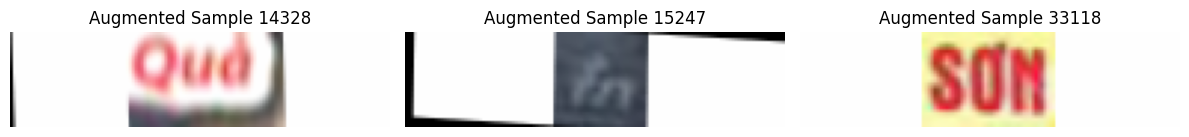

In [ ]:
# Cell 11: Data Augmentation và Transforms (Albumentations) (VinText)

# mean_img_transform và std_img_transform nên được định nghĩa ở Cell 2
# Nếu chưa có, bạn có thể định nghĩa lại ở đây hoặc lấy từ Cell 2.
if 'mean_img_transform' not in globals():
    print("Định nghĩa lại mean_img_transform và std_img_transform (nên ở Cell 2)")
    mean_img_transform = (0.485, 0.456, 0.406)
    std_img_transform = (0.229, 0.224, 0.225)

# 1. Transforms cho tập TRAIN (bao gồm augmentation)
train_transforms = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4), # Tăng nhẹ giới hạn và xác suất
    # A.GaussNoise(var_limit=(10.0, 40.0), mean=0, p=0.3), # Sửa hoặc bỏ nếu có warning về tham số
    # A.GaussNoise(p=0.2), # Dùng tham số mặc định nếu không chắc
    A.MotionBlur(blur_limit=(3, 5), p=0.2), # Giảm nhẹ blur_limit
    # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.2), # Biến dạng quang học nhẹ
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(-0.03, 0.03),
        rotate=(-3, 3), # Giữ xoay ở mức nhỏ vì ảnh từ thường đã khá thẳng
        shear=(-3,3),
        p=0.4, # Tăng nhẹ xác suất
        mode=cv2.BORDER_CONSTANT,
        cval=255 # Giá trị pixel cho padding (màu trắng, nếu ảnh có alpha thì cần cval=(255,255,255,0))
                 # Tuy nhiên, ảnh từ đã được xử lý thường không có alpha và nền trắng
    ),
    # A.GridDistortion(p=0.1), # Có thể thử
    A.Normalize(mean=mean_img_transform, std=std_img_transform),
    ToTensorV2()
])

# 2. Transforms cho tập VALIDATION và TEST (chỉ Normalize và ToTensor)
val_test_transforms = A.Compose([
    A.Normalize(mean=mean_img_transform, std=std_img_transform),
    ToTensorV2()
])

print("Đã định nghĩa train_transforms và val_test_transforms cho VinText.")

# --- Thử nghiệm transforms (Tùy chọn) ---
if 'PROCESSED_TRAIN_CSV' in globals() and os.path.exists(PROCESSED_TRAIN_CSV) and \
   'vocab_map' in globals() and vocab_map and 'MAX_TEXT_LEN' in globals() and \
   'VinTextWordDataset' in globals(): # Kiểm tra class Dataset mới

    print("\n--- Thử nghiệm train_transforms với một mẫu từ VinText ---")
    try:
        dataset_for_transform_test_vt = VinTextWordDataset( # Sử dụng class Dataset mới
            csv_file_path=PROCESSED_TRAIN_CSV,
            vocab_map_init=vocab_map,
            max_text_len_init=MAX_TEXT_LEN,
            img_transforms=train_transforms # Sử dụng train_transforms
        )
        if len(dataset_for_transform_test_vt) > 0:
            num_viz = 3
            fig, axes = plt.subplots(1, num_viz, figsize=(12, 4)) # Điều chỉnh figsize
            if num_viz == 1: axes = [axes]

            for i in range(min(num_viz, len(dataset_for_transform_test_vt))):
                sample_idx = random.randint(0, len(dataset_for_transform_test_vt) - 1)
                img_tensor_aug, _ = dataset_for_transform_test_vt[sample_idx]

                img_display_aug = img_tensor_aug.permute(1, 2, 0).cpu().numpy()
                img_display_aug = std_img_transform * img_display_aug + mean_img_transform
                img_display_aug = np.clip(img_display_aug, 0, 1)

                axes[i].imshow(img_display_aug)
                axes[i].set_title(f"Augmented Sample {sample_idx}")
                axes[i].axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("dataset_for_transform_test_vt rỗng.")
    except Exception as e_transform_test_vt:
        print(f"Lỗi khi thử nghiệm transforms cho VinText: {e_transform_test_vt}")
else:
    print("\nKhông đủ thông tin để thử nghiệm transforms cho VinText.")

In [ ]:
# Cell 12: Khởi tạo Datasets và DataLoaders (VinText)

proceed_dataloading_vintext = True
train_loader, val_loader, test_loader = None, None, None # Khởi tạo mặc định

try:
    # --- Khởi tạo Train Dataset và DataLoader ---
    if not os.path.exists(PROCESSED_TRAIN_CSV):
        print(f"Lỗi: File {PROCESSED_TRAIN_CSV} không tồn tại. Hãy chạy lại Cell 9.")
        proceed_dataloading_vintext = False
    else:
        print(f"\n--- Khởi tạo Train Dataset (VinText) từ: {PROCESSED_TRAIN_CSV} ---")
        train_dataset = VinTextWordDataset( # Sử dụng VinTextWordDataset
            csv_file_path=PROCESSED_TRAIN_CSV,
            vocab_map_init=vocab_map,
            max_text_len_init=MAX_TEXT_LEN,
            img_transforms=train_transforms # Từ Cell 11
        )
        if len(train_dataset) == 0:
            print(f"Cảnh báo: train_dataset rỗng sau khi đọc {PROCESSED_TRAIN_CSV}. Kiểm tra file CSV.")
            proceed_dataloading_vintext = False
        else:
            train_loader = DataLoader(
                train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                num_workers=2, pin_memory=True
            )
            print(f"Train Dataset và DataLoader đã được tạo. Số mẫu train: {len(train_dataset)}, Số batch: {len(train_loader)}")

    # --- Khởi tạo Validation Dataset và DataLoader ---
    if not os.path.exists(PROCESSED_VAL_CSV) and proceed_dataloading_vintext:
        print(f"Lỗi: File {PROCESSED_VAL_CSV} không tồn tại. Hãy chạy lại Cell 9.")
        proceed_dataloading_vintext = False
    elif proceed_dataloading_vintext:
        print(f"\n--- Khởi tạo Validation Dataset (VinText) từ: {PROCESSED_VAL_CSV} ---")
        val_dataset = VinTextWordDataset( # Sử dụng VinTextWordDataset
            csv_file_path=PROCESSED_VAL_CSV,
            vocab_map_init=vocab_map,
            max_text_len_init=MAX_TEXT_LEN,
            img_transforms=val_test_transforms # Từ Cell 11
        )
        if len(val_dataset) == 0:
            print(f"Cảnh báo: val_dataset rỗng sau khi đọc {PROCESSED_VAL_CSV}. Kiểm tra file CSV.")
            proceed_dataloading_vintext = False
        else:
            val_loader = DataLoader(
                val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                num_workers=2, pin_memory=True
            )
            print(f"Validation Dataset và DataLoader đã được tạo. Số mẫu validation: {len(val_dataset)}, Số batch: {len(val_loader)}")

    # --- Khởi tạo Test Dataset và DataLoader (VinText có nhãn cho test) ---
    if not os.path.exists(PROCESSED_TEST_CSV) and proceed_dataloading_vintext:
        print(f"Lỗi: File {PROCESSED_TEST_CSV} không tồn tại. Hãy chạy lại Cell 9.")
        proceed_dataloading_vintext = False
    elif proceed_dataloading_vintext:
        print(f"\n--- Khởi tạo Test Dataset (VinText) từ: {PROCESSED_TEST_CSV} ---")
        test_dataset = VinTextWordDataset( # Sử dụng VinTextWordDataset
            csv_file_path=PROCESSED_TEST_CSV,
            vocab_map_init=vocab_map,
            max_text_len_init=MAX_TEXT_LEN,
            img_transforms=val_test_transforms # Dùng val_test_transforms cho test
        )
        if len(test_dataset) == 0:
            print(f"Cảnh báo: test_dataset rỗng sau khi đọc {PROCESSED_TEST_CSV}. Kiểm tra file CSV.")
            # proceed_dataloading_vintext không cần đặt False ở đây vì train/val có thể vẫn dùng được
            test_loader = None
        else:
            test_loader = DataLoader(
                test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                num_workers=2, pin_memory=True
            )
            print(f"Test Dataset và DataLoader đã được tạo. Số mẫu test: {len(test_dataset)}, Số batch: {len(test_loader)}")

    if not proceed_dataloading_vintext:
         print("\nLỗi: Một hoặc nhiều DataLoader không thể được tạo do file CSV không tồn tại hoặc dataset tương ứng rỗng.")
         # Đảm bảo các loader có thể là None nếu bước trước lỗi
         if 'train_loader' not in locals() or train_loader is None: train_loader = None
         if 'val_loader' not in locals() or val_loader is None: val_loader = None
         if 'test_loader' not in locals() or test_loader is None: test_loader = None


except NameError as e:
    print(f"Lỗi NameError: {e}. Một biến cần thiết có thể chưa được định nghĩa. Hãy đảm bảo tất cả các cell trước đã được chạy.")
    proceed_dataloading_vintext = False
    train_loader, val_loader, test_loader = None, None, None
except Exception as e_dl_init_vt:
    print(f"Lỗi nghiêm trọng khi khởi tạo Datasets/DataLoaders cho VinText: {e_dl_init_vt}")
    proceed_dataloading_vintext = False
    train_loader, val_loader, test_loader = None, None, None


# --- Thử nghiệm DataLoaders (Tùy chọn) ---
# if proceed_dataloading_vintext and train_loader is not None:
#     print("\n--- Thử nghiệm lấy một batch từ train_loader (VinText) ---")
#     try:
#         sample_train_batch_imgs_vt, sample_train_batch_lbls_vt = next(iter(train_loader))
#         print(f"Kích thước batch ảnh train: {sample_train_batch_imgs_vt.shape}")
#         print(f"Kích thước batch nhãn train: {sample_train_batch_lbls_vt.shape}")

#         plt.figure(figsize=(6,3)) # Điều chỉnh figsize nếu cần
#         img_to_show_vt = sample_train_batch_imgs_vt[0].permute(1, 2, 0).cpu().numpy()
#         # mean/std_img_transform từ cell 2 hoặc 11
#         img_to_show_vt = std_img_transform * img_to_show_vt + mean_img_transform
#         img_to_show_vt = np.clip(img_to_show_vt, 0, 1)
#         plt.imshow(img_to_show_vt)

#         if 'decode_text' in globals() and 'vocab_map' in globals(): # decode_text từ cell 3/8/10
#             decoded_label_sample_vt = decode_text(sample_train_batch_lbls_vt[0], vocab_map)
#             plt.title(f"Mẫu từ Train Loader (VinText)\nNhãn: '{decoded_label_sample_vt}'", fontsize=10)
#         else:
#             plt.title(f"Mẫu từ Train Loader (VinText)", fontsize=10)
#         plt.axis('off')
#         plt.show()
#     except StopIteration:
#         print("Lỗi: train_loader rỗng, không thể lấy batch.")
#     except Exception as e_batch_test_vt:
#         print(f"Lỗi khi thử nghiệm train_loader (VinText): {e_batch_test_vt}")
# elif not proceed_dataloading_vintext:
#      print("\nKhông thể thử nghiệm DataLoaders do lỗi ở bước khởi tạo (VinText).")


--- Khởi tạo Train Dataset (VinText) từ: /content/vintext_output/train_processed_vintext.csv ---
Train Dataset và DataLoader đã được tạo. Số mẫu train: 34792, Số batch: 544

--- Khởi tạo Validation Dataset (VinText) từ: /content/vintext_output/val_processed_vintext.csv ---
Validation Dataset và DataLoader đã được tạo. Số mẫu validation: 8636, Số batch: 135

--- Khởi tạo Test Dataset (VinText) từ: /content/vintext_output/test_processed_vintext.csv ---
Test Dataset và DataLoader đã được tạo. Số mẫu test: 12234, Số batch: 192


In [ ]:
# Cell 13: Định nghĩa Kiến trúc Model (CNN-Transformer Decoder) (VinText - Rút gọn)

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=MAX_TEXT_LEN):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term[:pe[:, 1::2].size(1)])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- CNN Backbone ---
class CustomCNNBackbone(nn.Module):
    def __init__(self, output_dim=EMBED_DIM, input_channels=3):
        super().__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.cnn_output_channels_actual = 512
        layers = list(resnet.children())[:-2]
        self.backbone = nn.Sequential(*layers)
        self.conv_proj = nn.Conv2d(self.cnn_output_channels_actual, output_dim, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_proj(x)
        B, C, H_feat, W_feat = x.shape
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(B, H_feat * W_feat, C)
        return x

# --- OCR Model (CNN + Transformer Decoder) ---
class OCRWordModel(nn.Module):
    def __init__(self, vocab_size_model,
                 embed_dim=EMBED_DIM, nhead=NHEAD, num_decoder_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD_DECODER, max_seq_len_text_model=MAX_TEXT_LEN,
                 dropout=DROPOUT):
        super().__init__()
        self.embed_dim = embed_dim
        self.cnn = CustomCNNBackbone(output_dim=embed_dim)
        self.embedding = nn.Embedding(vocab_size_model, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_len=max_seq_len_text_model)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size_model)
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.normal_(self.embedding.weight, mean=0, std=self.embed_dim ** -0.5)
        nn.init.xavier_uniform_(self.fc_out.weight)
        if self.fc_out.bias is not None:
            nn.init.zeros_(self.fc_out.bias)

    def _generate_square_subsequent_mask(self, sz, device_to_use):
        mask = (torch.triu(torch.ones(sz, sz, device=device_to_use)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, images, tgt_seq, tgt_key_padding_mask=None):
        src_features = self.cnn(images)
        tgt_len = tgt_seq.size(1)
        device_fwd = next(self.parameters()).device

        tgt_mask = self._generate_square_subsequent_mask(tgt_len, device_fwd)
        tgt_emb = self.embedding(tgt_seq) * math.sqrt(self.embed_dim)
        tgt_emb = self.pos_encoder(tgt_emb)

        decoder_output = self.transformer_decoder(
            tgt_emb, src_features, tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=None
        )
        logits = self.fc_out(decoder_output)
        return logits

print("Đã định nghĩa các lớp Model: PositionalEncoding, CustomCNNBackbone, OCRWordModel")


Đã định nghĩa các lớp Model: PositionalEncoding, CustomCNNBackbone, OCRWordModel


In [ ]:
# Cell 14: Khởi tạo Model, Optimizer, Criterion, Scheduler (VinText - Rút gọn)

model_vintext = None
optimizer_vintext = None
criterion_vintext = None
scheduler_vintext = None
proceed_model_init_vintext = True

try:
    print(f"\n--- Khởi tạo OCRWordModel cho VinText ---")
    print(f"Sử dụng VOCAB_SIZE (VinText): {VOCAB_SIZE}")
    print(f"Sử dụng MAX_TEXT_LEN (VinText, cho PositionalEncoding): {MAX_TEXT_LEN}")

    model_vintext = OCRWordModel(
        vocab_size_model=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        nhead=NHEAD,
        num_decoder_layers=NUM_DECODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD_DECODER,
        max_seq_len_text_model=MAX_TEXT_LEN,
        dropout=0.4
    )

    model_vintext.to(device)
    print(f"Model VinText đã được khởi tạo và chuyển sang device: {device}")

    num_params_vintext = sum(p.numel() for p in model_vintext.parameters() if p.requires_grad)
    print(f"Tổng số tham số có thể huấn luyện của model VinText: {num_params_vintext:,}")

    optimizer_vintext = optim.AdamW(model_vintext.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    print(f"\nOptimizer AdamW cho VinText đã được khởi tạo với LR={LEARNING_RATE}.")

    criterion_vintext = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    print(f"Criterion CrossEntropyLoss cho VinText đã được khởi tạo (ignore_index={PAD_IDX}).")

    scheduler_vintext = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_vintext, mode='min', factor=0.2, patience=5, verbose=True
    )
    print("Scheduler ReduceLROnPlateau cho VinText đã được khởi tạo.")

except NameError as e:
    print(f"Lỗi NameError khi khởi tạo model/components cho VinText: {e}")
    proceed_model_init_vintext = False
except Exception as e_model_init_vt:
    print(f"Lỗi không xác định khi khởi tạo model/components cho VinText: {e_model_init_vt}")
    proceed_model_init_vintext = False

if not proceed_model_init_vintext:
    print("\nLỗi trong quá trình khởi tạo model VinText hoặc các thành phần liên quan.")
else:
    print("\nModel VinText, Optimizer, Criterion, và Scheduler đã sẵn sàng cho việc huấn luyện.")


--- Khởi tạo OCRWordModel cho VinText ---
Sử dụng VOCAB_SIZE (VinText): 230
Sử dụng MAX_TEXT_LEN (VinText, cho PositionalEncoding): 13
Model VinText đã được khởi tạo và chuyển sang device: cuda
Tổng số tham số có thể huấn luyện của model VinText: 25,747,750

Optimizer AdamW cho VinText đã được khởi tạo với LR=0.0001.
Criterion CrossEntropyLoss cho VinText đã được khởi tạo (ignore_index=0).
Scheduler ReduceLROnPlateau cho VinText đã được khởi tạo.

Model VinText, Optimizer, Criterion, và Scheduler đã sẵn sàng cho việc huấn luyện.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Cell 15: Vòng lặp Huấn luyện (Training Loop) (VinText)

# --- Hàm Inference cho Validation Loop (nếu chưa định nghĩa ở cell này) ---
if 'ocr_infer_val' not in globals():
    def ocr_infer_val(model_to_infer, cnn_features, vocab_map_infer, device_infer,
                      max_len_infer=MAX_TEXT_LEN, sos_idx_infer=SOS_IDX, eos_idx_infer=EOS_IDX):
        model_to_infer.eval()
        batch_size = cnn_features.size(0)
        output_sequences_indices = torch.full((batch_size, 1), sos_idx_infer, dtype=torch.long, device=device_infer)
        with torch.no_grad():
            for _ in range(max_len_infer -1):
                current_tgt_len = output_sequences_indices.size(1)
                tgt_mask = model_to_infer._generate_square_subsequent_mask(current_tgt_len, device_infer)
                tgt_emb = model_to_infer.embedding(output_sequences_indices) * math.sqrt(model_to_infer.embed_dim)
                tgt_emb = model_to_infer.pos_encoder(tgt_emb)
                decoder_output = model_to_infer.transformer_decoder(
                    tgt_emb, cnn_features, tgt_mask=tgt_mask
                )
                logits = model_to_infer.fc_out(decoder_output[:, -1, :])
                predicted_token_indices = logits.argmax(dim=-1).unsqueeze(1)
                output_sequences_indices = torch.cat([output_sequences_indices, predicted_token_indices], dim=1)
                # if (predicted_token_indices == eos_idx_infer).all(): # Tùy chọn dừng sớm
                #     break
        predicted_texts = []
        for i in range(batch_size):
            pred_text = decode_text(output_sequences_indices[i, 1:].cpu(), vocab_map_infer)
            predicted_texts.append(pred_text)
        return predicted_texts
    print("Hàm ocr_infer_val đã được định nghĩa/kiểm tra.")

# --- Kiểm tra các biến cần thiết ---
# (Giả sử các biến đã được kiểm tra và sẵn sàng từ Cell 14)
if 'model_vintext' in globals() and model_vintext is not None and \
   'train_loader' in globals() and train_loader is not None and \
   'val_loader' in globals() and val_loader is not None and \
   'optimizer_vintext' in globals() and optimizer_vintext is not None and \
   'criterion_vintext' in globals() and criterion_vintext is not None and \
   'scheduler_vintext' in globals() and scheduler_vintext is not None:

    print(f"\n--- Bắt đầu Huấn luyện Model cho VinText ---")
    print(f"Device: {device}, Số Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, Learning Rate ban đầu: {LEARNING_RATE}")

    best_val_cer_vintext = float('inf')
    epochs_no_improve_vintext = 0
    # PATIENCE_EARLY_STOPPING đã được định nghĩa là 15 ở lần trước, có thể dùng lại hoặc định nghĩa mới
    if 'PATIENCE_EARLY_STOPPING' not in globals():
        PATIENCE_EARLY_STOPPING = 15 # Giá trị mặc định nếu chưa có
        print(f"PATIENCE_EARLY_STOPPING được đặt mặc định là {PATIENCE_EARLY_STOPPING}")


    for epoch in range(NUM_EPOCHS): # NUM_EPOCHS từ Cell 2
        # --- PHA HUẤN LUYỆN ---
        model_vintext.train()
        total_train_loss = 0
        progress_bar_train = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{NUM_EPOCHS} (VinText)", leave=False)

        for images, tgt_sequences in progress_bar_train:
            images = images.to(device)
            tgt_sequences = tgt_sequences.to(device)

            optimizer_vintext.zero_grad()

            tgt_input = tgt_sequences[:, :-1]
            tgt_output = tgt_sequences[:, 1:]
            tgt_key_padding_mask = (tgt_input == PAD_IDX).to(device)

            logits = model_vintext(images, tgt_input, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion_vintext(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_vintext.parameters(), CLIP_VALUE) # CLIP_VALUE từ Cell 2
            optimizer_vintext.step()

            total_train_loss += loss.item()
            progress_bar_train.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        # --- PHA ĐÁNH GIÁ ---
        model_vintext.eval()
        total_val_loss = 0
        all_val_preds = []
        all_val_gts = []
        progress_bar_val = tqdm(val_loader, desc=f"Valid Epoch {epoch+1}/{NUM_EPOCHS} (VinText)", leave=False)

        with torch.no_grad():
            for images_val, tgt_sequences_val in progress_bar_val:
                images_val = images_val.to(device)
                tgt_sequences_val = tgt_sequences_val.to(device)

                tgt_input_val = tgt_sequences_val[:, :-1]
                tgt_output_val = tgt_sequences_val[:, 1:]
                tgt_key_padding_mask_val = (tgt_input_val == PAD_IDX).to(device)

                logits_val = model_vintext(images_val, tgt_input_val, tgt_key_padding_mask=tgt_key_padding_mask_val)
                loss_val = criterion_vintext(logits_val.reshape(-1, logits_val.shape[-1]), tgt_output_val.reshape(-1))
                total_val_loss += loss_val.item()

                cnn_features_val = model_vintext.cnn(images_val)
                # Truyền các IDX vào ocr_infer_val
                batch_preds_text = ocr_infer_val(model_vintext, cnn_features_val, vocab_map, device,
                                                 max_len_infer=MAX_TEXT_LEN,
                                                 sos_idx_infer=SOS_IDX,
                                                 eos_idx_infer=EOS_IDX)
                all_val_preds.extend(batch_preds_text)

                for i in range(tgt_output_val.size(0)):
                    # decode_text cần PAD_IDX, SOS_IDX, EOS_IDX (global) và vocab_map
                    gt_text = decode_text(tgt_output_val[i].cpu(), vocab_map)
                    all_val_gts.append(gt_text)

        avg_val_loss = total_val_loss / len(val_loader)
        val_cer = 0.0
        if all_val_gts and all_val_preds:
            val_cer = cer(all_val_gts, all_val_preds)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} (VinText): Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Val CER={val_cer:.4f}")

        scheduler_vintext.step(val_cer)

        if val_cer < best_val_cer_vintext:
            best_val_cer_vintext = val_cer
            # MODEL_SAVE_PATH từ Cell 2 (đã đặt tên cho VinText)
            torch.save(model_vintext.state_dict(), MODEL_SAVE_PATH)
            print(f"  Val CER improved to {val_cer:.4f}. Model VinText saved to {MODEL_SAVE_PATH}")
            epochs_no_improve_vintext = 0
        else:
            epochs_no_improve_vintext += 1
            print(f"  Val CER did not improve. Count: {epochs_no_improve_vintext}/{PATIENCE_EARLY_STOPPING}")
            if epochs_no_improve_vintext >= PATIENCE_EARLY_STOPPING:
                print(f"Early stopping triggered for VinText after {epoch+1} epochs.")
                break

    print("\n--- Huấn luyện Model VinText hoàn tất ---")

else:
    print("Lỗi: Model VinText hoặc các thành phần huấn luyện chưa được khởi tạo. Không thể bắt đầu huấn luyện.")


--- Bắt đầu Huấn luyện Model cho VinText ---
Device: cuda, Số Epochs: 20, Batch Size: 64, Learning Rate ban đầu: 0.0001


Train Epoch 1/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Valid Epoch 1/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 1/20 (VinText): Train Loss=2.5991 | Val Loss=2.0620 | Val CER=0.7580
  Val CER improved to 0.7580. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 2/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 2/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 2/20 (VinText): Train Loss=1.7405 | Val Loss=1.5997 | Val CER=0.5995
  Val CER improved to 0.5995. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 3/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 3/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 3/20 (VinText): Train Loss=1.3930 | Val Loss=1.3503 | Val CER=0.5320
  Val CER improved to 0.5320. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 4/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 4/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 4/20 (VinText): Train Loss=1.1787 | Val Loss=1.2221 | Val CER=0.4699
  Val CER improved to 0.4699. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 5/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 5/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 5/20 (VinText): Train Loss=1.0372 | Val Loss=1.1521 | Val CER=0.4470
  Val CER improved to 0.4470. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 6/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 6/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 6/20 (VinText): Train Loss=0.9259 | Val Loss=1.1059 | Val CER=0.4206
  Val CER improved to 0.4206. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 7/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 7/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 7/20 (VinText): Train Loss=0.8389 | Val Loss=1.0785 | Val CER=0.4079
  Val CER improved to 0.4079. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 8/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 8/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 8/20 (VinText): Train Loss=0.7613 | Val Loss=1.0285 | Val CER=0.4015
  Val CER improved to 0.4015. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 9/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 9/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 9/20 (VinText): Train Loss=0.6971 | Val Loss=1.0093 | Val CER=0.3862
  Val CER improved to 0.3862. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 10/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 10/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 10/20 (VinText): Train Loss=0.6353 | Val Loss=0.9954 | Val CER=0.3717
  Val CER improved to 0.3717. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 11/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 11/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 11/20 (VinText): Train Loss=0.5869 | Val Loss=0.9982 | Val CER=0.3670
  Val CER improved to 0.3670. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 12/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 12/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 12/20 (VinText): Train Loss=0.5427 | Val Loss=0.9797 | Val CER=0.3606
  Val CER improved to 0.3606. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 13/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 13/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 13/20 (VinText): Train Loss=0.5015 | Val Loss=0.9864 | Val CER=0.3555
  Val CER improved to 0.3555. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 14/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 14/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 14/20 (VinText): Train Loss=0.4677 | Val Loss=0.9955 | Val CER=0.3563
  Val CER did not improve. Count: 1/15


Train Epoch 15/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 15/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 15/20 (VinText): Train Loss=0.4356 | Val Loss=0.9970 | Val CER=0.3491
  Val CER improved to 0.3491. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 16/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 16/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 16/20 (VinText): Train Loss=0.4078 | Val Loss=1.0058 | Val CER=0.3489
  Val CER improved to 0.3489. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 17/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 17/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 17/20 (VinText): Train Loss=0.3821 | Val Loss=1.0290 | Val CER=0.3460
  Val CER improved to 0.3460. Model VinText saved to /content/vintext_output/vintext_ocr_model_best.pth


Train Epoch 18/20 (VinText):   0%|          | 0/544 [00:00<?, ?it/s]

Valid Epoch 18/20 (VinText):   0%|          | 0/135 [00:00<?, ?it/s]

KeyboardInterrupt: 